In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('..')

This notebook is a guide for the neural networks based models of the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [Linear](#first-bullet)
* [MLP](#second-bullet)
* [Autoencoder](#third-bullet)
* [GRIN](#fourth-bullet)

All neural networks based models are trained following the same procedure implemented by the Filler. 

### Linear training <a class="anchor" id="first-bullet"></a>

In [2]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from trainer.Filler import Filler

from types import SimpleNamespace

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.75
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(linear, model_kwargs, filler_kwargs)

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [4]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader)
filler.save_model('../trained_models/linear.pt')

start training
Epoch 1/100, Train Loss: 49.39957333, Test Loss: 45.21846008, time: 0.45s
Epoch 2/100, Train Loss: 27.39929867, Test Loss: 25.61414591, time: 0.71s
Epoch 3/100, Train Loss: 17.21681094, Test Loss: 17.53738276, time: 0.94s
Epoch 4/100, Train Loss: 13.01830125, Test Loss: 15.00481606, time: 1.18s
Epoch 5/100, Train Loss: 11.55161929, Test Loss: 14.35292975, time: 1.42s
Epoch 6/100, Train Loss: 11.16949630, Test Loss: 13.72793706, time: 1.65s
Epoch 7/100, Train Loss: 10.53089333, Test Loss: 13.01988856, time: 1.88s
Epoch 8/100, Train Loss: 10.13874412, Test Loss: 12.30595907, time: 2.11s
Epoch 9/100, Train Loss: 9.72049665, Test Loss: 11.72152615, time: 2.35s
Epoch 10/100, Train Loss: 9.37753654, Test Loss: 11.35594495, time: 2.58s
Epoch 11/100, Train Loss: 9.17438698, Test Loss: 11.15448888, time: 2.81s
Epoch 12/100, Train Loss: 8.93834686, Test Loss: 10.98875968, time: 3.04s
Epoch 13/100, Train Loss: 8.85468674, Test Loss: 10.79509322, time: 3.29s
Epoch 14/100, Train Loss

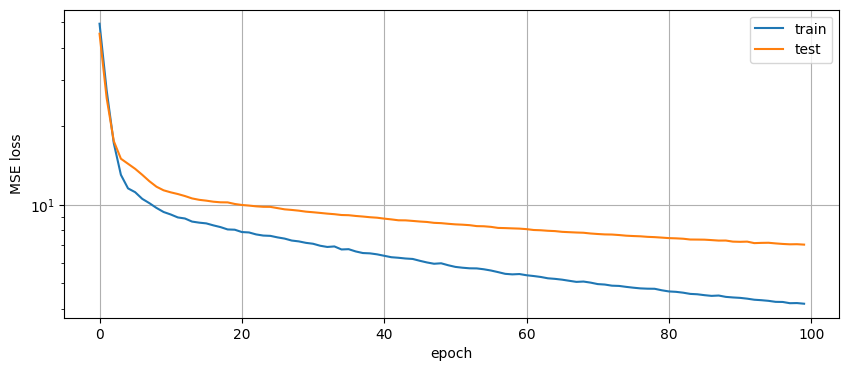

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
# plt.ylim(0.01, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()

### MLP training <a class="anchor" id="second-bullet"></a>

In [6]:
from data_provider.data_provider import DataProvider
from models.MLP import MLP
from trainer.Filler import Filler

from types import SimpleNamespace

In [7]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(seq_dim=data_provider.data.n_nodes, hidden_dim=2*data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(MLP, model_kwargs, filler_kwargs)

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [8]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader)
filler.save_model('../trained_models/MLP.pt')

start training
Epoch 1/100, Train Loss: 17.08347201, Test Loss: 13.38141759, time: 0.72s
Epoch 2/100, Train Loss: 9.94515300, Test Loss: 11.19792875, time: 1.47s
Epoch 3/100, Train Loss: 8.44318330, Test Loss: 11.29594262, time: 2.23s
Epoch 4/100, Train Loss: 7.67869997, Test Loss: 10.62306309, time: 2.98s
Epoch 5/100, Train Loss: 7.18283093, Test Loss: 9.89661535, time: 3.75s
Epoch 6/100, Train Loss: 6.63424230, Test Loss: 9.29721928, time: 4.53s
Epoch 7/100, Train Loss: 6.19656515, Test Loss: 8.93552430, time: 5.23s
Epoch 8/100, Train Loss: 5.84299469, Test Loss: 8.66295020, time: 5.91s
Epoch 9/100, Train Loss: 5.46230352, Test Loss: 8.23512125, time: 6.59s
Epoch 10/100, Train Loss: 5.17758739, Test Loss: 7.97468281, time: 7.27s
Epoch 11/100, Train Loss: 4.90539324, Test Loss: 7.65005239, time: 7.98s
Epoch 12/100, Train Loss: 4.64790094, Test Loss: 7.33751806, time: 8.65s
Epoch 13/100, Train Loss: 4.43967092, Test Loss: 6.97550821, time: 9.33s
Epoch 14/100, Train Loss: 4.24302697, Te

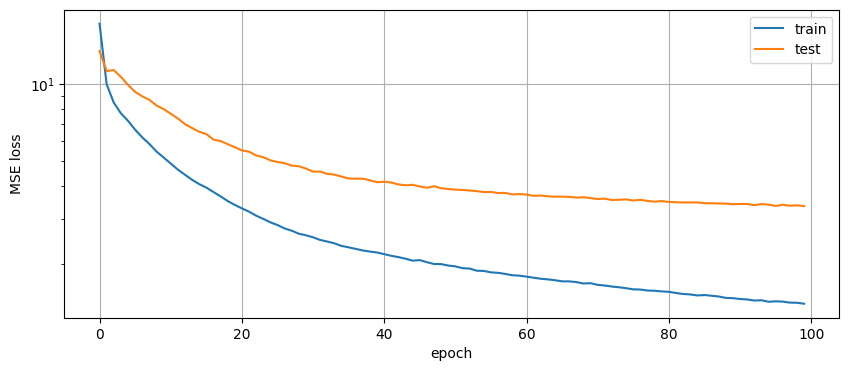

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
# plt.ylim(0.01, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()

### Autoencoder <a class="anchor" id="third-bullet"></a>

In [10]:
from data_provider.data_provider import DataProvider
from models.MLP import MLP
from trainer.Filler import Filler

from types import SimpleNamespace

In [11]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(seq_dim=data_provider.data.n_nodes, hidden_dim=int(0.25*data_provider.data.n_nodes))
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(MLP, model_kwargs, filler_kwargs)

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [12]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader)
filler.save_model('../trained_models/autoencoder.pt')

start training
Epoch 1/100, Train Loss: 21.58222342, Test Loss: 20.57162094, time: 0.22s
Epoch 2/100, Train Loss: 16.25069809, Test Loss: 16.13443947, time: 0.42s
Epoch 3/100, Train Loss: 13.83883357, Test Loss: 14.24723434, time: 0.62s
Epoch 4/100, Train Loss: 12.65988564, Test Loss: 13.36732896, time: 0.82s
Epoch 5/100, Train Loss: 12.07682633, Test Loss: 12.89535014, time: 1.02s
Epoch 6/100, Train Loss: 11.68512321, Test Loss: 12.60501703, time: 1.22s
Epoch 7/100, Train Loss: 11.35813427, Test Loss: 12.33640226, time: 1.42s
Epoch 8/100, Train Loss: 11.10918713, Test Loss: 12.15375868, time: 1.61s
Epoch 9/100, Train Loss: 10.80164385, Test Loss: 11.94201342, time: 1.80s
Epoch 10/100, Train Loss: 10.44253898, Test Loss: 11.73519230, time: 2.00s
Epoch 11/100, Train Loss: 10.12604570, Test Loss: 11.43060080, time: 2.19s
Epoch 12/100, Train Loss: 9.74909949, Test Loss: 11.15970103, time: 2.40s
Epoch 13/100, Train Loss: 9.40842938, Test Loss: 10.92138894, time: 2.59s
Epoch 14/100, Train L

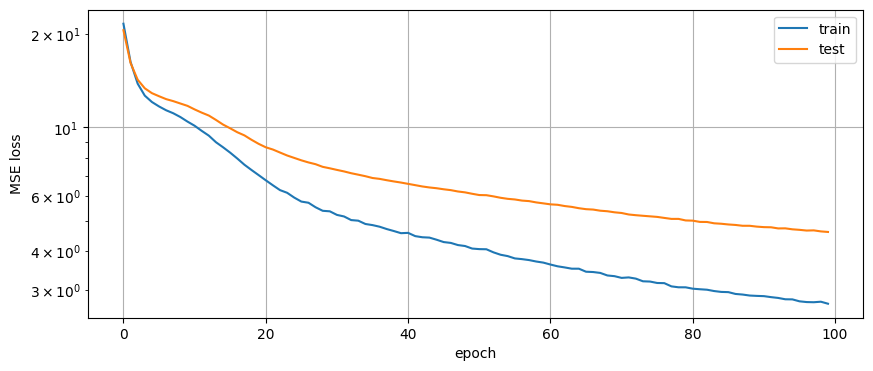

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
# plt.ylim(0.01, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()

### GRIN <a class="anchor" id="fourth-bullet"></a>

In [2]:
from data_provider.data_provider import DataProvider
from models.GRIN import GRINet
from trainer.Filler import Filler

from types import SimpleNamespace

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


device:  cpu


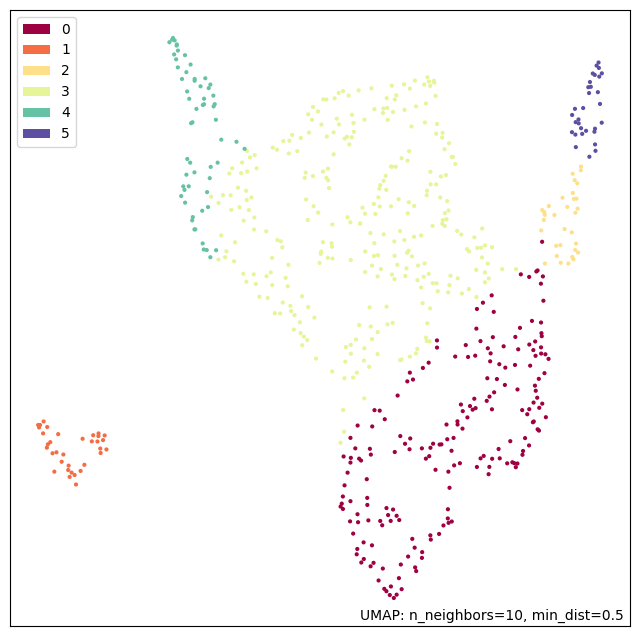

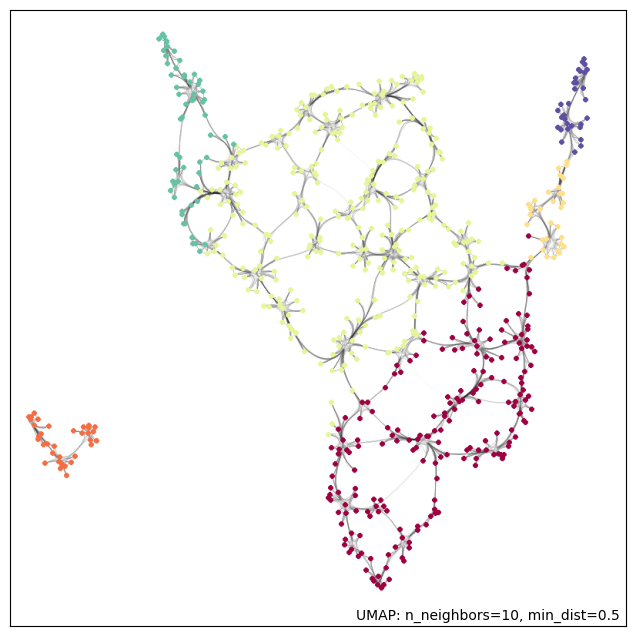

In [3]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.scaler = None
data_kwargs.batch_size = 15
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
adjacency_matrix = data_provider.data.umap_adjacency(threshold=0.99, verbose=True)
ordered_indices = scipy.sparse.csgraph.reverse_cuthill_mckee(graph=scipy.sparse.csr_matrix(adjacency_matrix), symmetric_mode=True)
adjacency_matrix = torch.tensor(adjacency_matrix[ordered_indices, :][:, ordered_indices]).to('cuda:0' if torch.cuda.is_available() else 'cpu')
#adjacency_matrix = torch.FloatTensor(data_provider.data.correlation_adjacency())
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(adj=adjacency_matrix, d_in=1)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-5
filler_kwargs.epochs = 10
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(GRINet, model_kwargs, filler_kwargs)

In [4]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader)

start training
Epoch 1/10, Train Loss: 165.53870509, Test Loss: 247.29256668, time: 244.51s


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.ylim(0, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()